In [1]:
# ============================
# 1. Imports
# ============================
import os
import cv2
import numpy as np
import albumentations as A
import shutil
import zipfile

# ============================
# 2. Paths
# ============================
input_dir = "/kaggle/input/new-dataset-cucumber-disease-8-classes/New data set"
output_dir = "/kaggle/working/augmentation"

os.makedirs(output_dir, exist_ok=True)

# ============================
# 3. Define Augmentations
# ============================
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Affine(
        scale=(0.75, 1.25),
        translate_percent=(0.0, 0.15),
        rotate=(-30, 30),
        p=0.7
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.25,
        contrast_limit=0.25,
        p=0.7
    )
])

# ============================
# 4. Process Each Class
# ============================
num_augmented = 3   # number of augmented versions per image
valid_exts = (".jpg", ".jpeg", ".png", ".bmp")

for root, dirs, files in os.walk(input_dir):
    rel_path = os.path.relpath(root, input_dir)
    class_output_path = os.path.join(output_dir, rel_path)
    os.makedirs(class_output_path, exist_ok=True)

    for file_name in files:
        if not file_name.lower().endswith(valid_exts):
            continue  # skip non-images

        src = os.path.join(root, file_name)
        dst = os.path.join(class_output_path, file_name)

        # Copy original image
        shutil.copy2(src, dst)

        # Load image for augmentation
        image = cv2.imread(src)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Generate augmentations
        for i in range(num_augmented):
            augmented = transform(image=image)
            aug_img = augmented["image"]

            aug_filename = f"{os.path.splitext(file_name)[0]}_aug{i+1}.jpg"
            aug_path = os.path.join(class_output_path, aug_filename)
            cv2.imwrite(aug_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

print("✅ Augmentation complete. Dataset saved in:", output_dir)

# ============================
# 5. Zip the Augmented Dataset
# ============================
zip_path = "/kaggle/working/augmentation.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, output_dir))

print("✅ Zipped dataset ready at:", zip_path)


✅ Augmentation complete. Dataset saved in: /kaggle/working/augmentation
✅ Zipped dataset ready at: /kaggle/working/augmentation.zip


In [2]:
# ============================
# 1. Imports
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

# ============================
# 2. Device Config
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
# ============================
# 3. Dataset & Dataloaders
# ============================
data_dir = "//kaggle/working/augmentation"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Split (70% train, 80% val, 10% test)
train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']
Train: 4124, Val: 515, Test: 517


In [4]:
import timm

# ============================
# 4. Model, Loss, Optimizer (Xception)
# ============================
# Create pretrained Xception
model = timm.create_model("xception", pretrained=True)

# Replace classifier / “head” for your dataset
# The head for xception is typically a Linear layer
in_features = model.get_classifier().in_features
model.reset_classifier(num_classes=num_classes)

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [5]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # -----------------------------
        # Training phase
        # -----------------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc  = correct / total

        # -----------------------------
        # Validation phase
        # -----------------------------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        loop_val = tqdm(val_loader, desc=f"Val {epoch+1}/{epochs}", leave=False)

        with torch.no_grad():
            for images, labels in loop_val:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                loop_val.set_postfix(loss=loss.item())

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


# ============================
# Run Training
# ============================
num_epochs = 20
history = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)



Epoch 1/20


Epoch 1/20 - Train Loss: 0.6788, Train Acc: 0.8269, Val Loss: 0.1215, Val Acc: 0.9767

Epoch 2/20


Epoch 2/20 - Train Loss: 0.0937, Train Acc: 0.9794, Val Loss: 0.0495, Val Acc: 0.9883

Epoch 3/20


Epoch 3/20 - Train Loss: 0.0320, Train Acc: 0.9949, Val Loss: 0.0340, Val Acc: 0.9845

Epoch 4/20


Epoch 4/20 - Train Loss: 0.0186, Train Acc: 0.9971, Val Loss: 0.0232, Val Acc: 0.9922

Epoch 5/20


Epoch 5/20 - Train Loss: 0.0145, Train Acc: 0.9976, Val Loss: 0.0270, Val Acc: 0.9903

Epoch 6/20


Epoch 6/20 - Train Loss: 0.0085, Train Acc: 0.9985, Val Loss: 0.0329, Val Acc: 0.9845

Epoch 7/20


Epoch 7/20 - Train Loss: 0.0230, Train Acc: 0.9949, Val Loss: 0.0705, Val Acc: 0.9786

Epoch 8/20


Epoch 8/20 - Train Loss: 0.0160, Train Acc: 0.9954, Val Loss: 0.0451, Val Acc: 0.9864

Epoch 9/20


Epoch 9/20 - Train Loss: 0.0148, Train Acc: 0.9964, Val Loss: 0.0496, Val Acc: 0.9903

Epoch 10/20


Epoch 10/20 - Train Loss: 0.0082, Train Acc: 0.9985, Val Loss: 0.0373, Val Acc: 0.9922

Epoch 11/20


Epoch 11/20 - Train Loss: 0.0096, Train Acc: 0.9971, Val Loss: 0.0571, Val Acc: 0.9806

Epoch 12/20


Epoch 12/20 - Train Loss: 0.0111, Train Acc: 0.9966, Val Loss: 0.0775, Val Acc: 0.9845

Epoch 13/20


Epoch 13/20 - Train Loss: 0.0108, Train Acc: 0.9966, Val Loss: 0.0466, Val Acc: 0.9786

Epoch 14/20


Epoch 14/20 - Train Loss: 0.0033, Train Acc: 0.9995, Val Loss: 0.0486, Val Acc: 0.9786

Epoch 15/20


Epoch 15/20 - Train Loss: 0.0091, Train Acc: 0.9973, Val Loss: 0.1157, Val Acc: 0.9689

Epoch 16/20


Epoch 16/20 - Train Loss: 0.0113, Train Acc: 0.9971, Val Loss: 0.0908, Val Acc: 0.9767

Epoch 17/20


Epoch 17/20 - Train Loss: 0.0069, Train Acc: 0.9976, Val Loss: 0.0809, Val Acc: 0.9748

Epoch 18/20


Epoch 18/20 - Train Loss: 0.0070, Train Acc: 0.9976, Val Loss: 0.0399, Val Acc: 0.9786

Epoch 19/20


Epoch 19/20 - Train Loss: 0.0079, Train Acc: 0.9983, Val Loss: 0.0445, Val Acc: 0.9883

Epoch 20/20


Epoch 20/20 - Train Loss: 0.0052, Train Acc: 0.9985, Val Loss: 0.0466, Val Acc: 0.9845


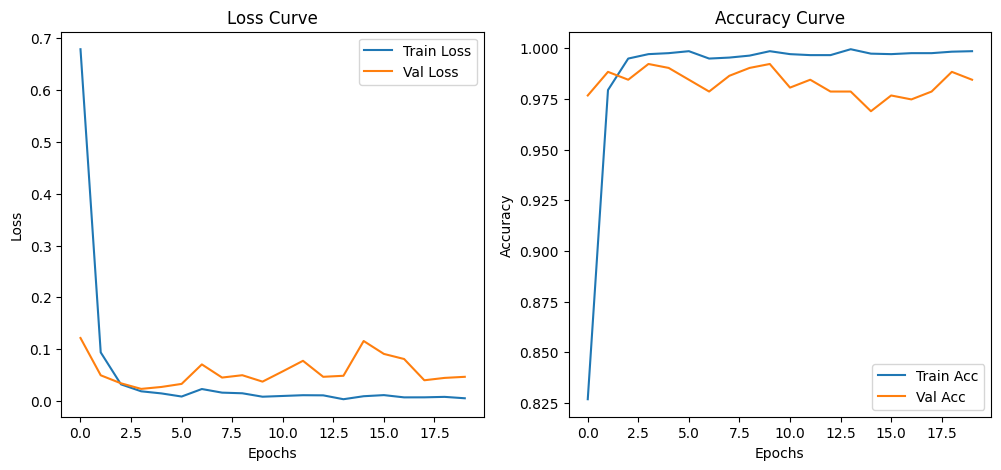

In [6]:
# ============================
# 6. Plot Training Curves
# ============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy Curve")

plt.show()


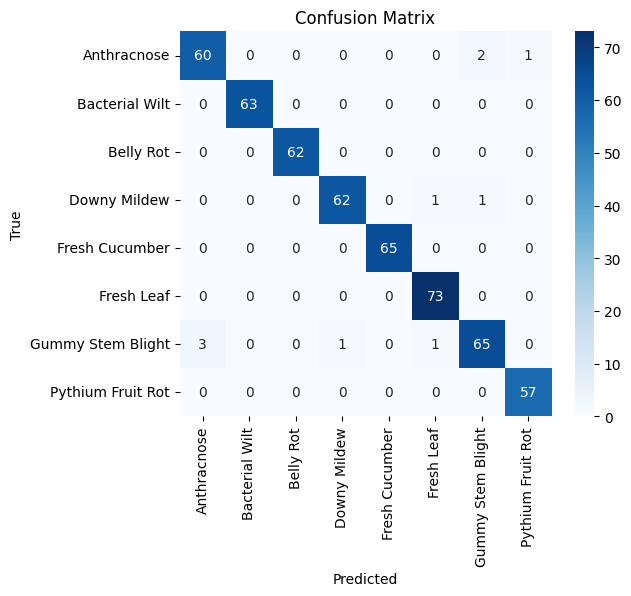


=== Test Metrics ===
Accuracy: 0.9807
Precision: 0.9811
Recall:    0.9812
F1 Score:  0.9811


In [7]:
# ============================
# 7. Evaluation Function
# ============================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for img_rgb, labels in test_loader:  # no scharr now
            img_rgb = img_rgb.to(device)
            labels = labels.to(device)

            out = model(img_rgb)             # forward with RGB only
            preds = out.argmax(1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print("\n=== Test Metrics ===")
    print(f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall:    {rec:.4f}\nF1 Score:  {f1:.4f}")
    return acc, prec, rec, f1

# Usage
test_metrics = evaluate_model(model, test_loader, class_names, device)
